In [1]:
!pip install niapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 78.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.5
    Uninstalling matplotlib-3.7.5:
      Successfully uninstalled matplotlib-3.7.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [14]:
from typing import Callable, List
from collections import defaultdict

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer   
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier


import warnings

warnings.filterwarnings("ignore")

In [3]:
train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")
train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
test_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_identity.csv")
test_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")

In [6]:
target_feature = "isFraud"
nan_fracs = train_transaction.isna().mean()
feats_to_remove = nan_fracs[nan_fracs > 0.6].index.tolist()
train_transaction = train_transaction.drop(columns=feats_to_remove)

cat_features = train_transaction.select_dtypes(include=["object"]).columns.tolist()
num_features = train_transaction.select_dtypes(include=["number"]).columns.tolist()

for feat in cat_features:
    if train_transaction[feat].nunique() < 2 or train_transaction[feat].nunique() > 10:
        cat_features.remove(feat)

if target_feature in cat_features:
    cat_features.remove(target_feature)
if target_feature in num_features:
    num_features.remove(target_feature)

all_features = cat_features + num_features

train_transaction_subsample = train_transaction.sample(
    n=100000, random_state=42
)  # subsample for faster experiments

train_data, val_data = train_test_split(
    train_transaction_subsample,
    test_size=0.2,
    random_state=42,
    stratify=train_transaction_subsample["isFraud"],
)


In [7]:
x_train = train_data[all_features]
y_train = train_data["isFraud"]
x_val = val_data[all_features]
y_val = val_data["isFraud"]

In [17]:
import catboost

train_data[cat_features] = train_data[cat_features].astype(str)
val_data[cat_features] = val_data[cat_features].astype(str)

train_pool = catboost.Pool(
    data=train_data[all_features],
    label=train_data["isFraud"],
    cat_features=cat_features,
)
val_pool = catboost.Pool(
    data=val_data[all_features],
    label=val_data["isFraud"],
    cat_features=cat_features,
)


def catboost_fn():
    return catboost.CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        depth=7,
        eval_metric="Accuracy",
        random_seed=42,
        verbose=False,
        task_type="GPU",
        devices="0",
    )


In [18]:
import lightgbm


def lgbm_fn():
    return lightgbm.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42,
        metric="auc",
        verbose=-1,
    )


In [19]:
def tree_fn():
    return DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
    )

In [37]:
from niapy.problems import Problem


class CatBoostProblem(Problem):
    def __init__(
        self,
        model_fn: Callable,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        x_val: pd.DataFrame,
        y_val: pd.Series,
        cat_features: List[str],
    ):
        self.model_fn = model_fn
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.cat_features = cat_features
        self.x_train[cat_features] = self.x_train[cat_features].astype(str)
        self.x_val[cat_features] = self.x_val[cat_features].astype(str)

        super().__init__(dimension=len(x_train.columns), lower=-1, upper=1)

    def _evaluate(self, x: np.ndarray) -> float:
        all_feats = self.x_train.columns.tolist()
        features_to_use = [all_feats[i] for i in range(len(all_feats)) if x[i] >= 0]

        if len(features_to_use) == 0:
            return -1

        cat_features = [feat for feat in self.cat_features if feat in features_to_use]

        train_pool = catboost.Pool(
            data=self.x_train[features_to_use],
            label=self.y_train,
            cat_features=cat_features,
        )
        val_pool = catboost.Pool(
            data=self.x_val[features_to_use],
            label=self.y_val,
            cat_features=cat_features,
        )
        model = self.model_fn()
        model.fit(
            train_pool,
            eval_set=val_pool,
        )

        y_pred = model.predict_proba(self.x_val[features_to_use])[:, 1]
        auc = roc_auc_score(self.y_val, y_pred)
        return -auc


class LGBMProblem(Problem):
    def __init__(
        self,
        model_fn: Callable,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        x_val: pd.DataFrame,
        y_val: pd.Series,
        cat_features: List[str],
    ):
        self.model_fn = model_fn
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.cat_features = cat_features
        self.x_train[cat_features] = self.x_train[cat_features].astype("category")
        self.x_val[cat_features] = self.x_val[cat_features].astype("category")

        super().__init__(dimension=len(x_train.columns), lower=-1, upper=1)

    def _evaluate(self, x: np.ndarray) -> float:
        all_feats = self.x_train.columns.tolist()
        features_to_use = [all_feats[i] for i in range(len(all_feats)) if x[i] >= 0]

        if len(features_to_use) == 0:
            return -1

        cat_features = [feat for feat in self.cat_features if feat in features_to_use]

        model = self.model_fn()
        model.fit(
            self.x_train[features_to_use],
            self.y_train,
            eval_set=(self.x_val[features_to_use], self.y_val),
            categorical_feature=cat_features,
        )

        y_pred = model.predict_proba(self.x_val[features_to_use])[:, 1]
        auc = roc_auc_score(self.y_val, y_pred)
        return -auc


class TreeProblem(Problem):
    def __init__(
        self,
        model_fn: Callable,
        x_train: pd.DataFrame,
        y_train: pd.Series,
        x_val: pd.DataFrame,
        y_val: pd.Series,
        cat_features: List[str],
    ):
        self.model_fn = model_fn
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.cat_features = cat_features

        super().__init__(dimension=len(x_train.columns), lower=-1, upper=1)

    def _evaluate(self, x: np.ndarray) -> float:
        all_feats = self.x_train.columns.tolist()
        features_to_use = [all_feats[i] for i in range(len(all_feats)) if x[i] >= 0]

        if len(features_to_use) == 0:
            return -1

        cat_features = [feat for feat in self.cat_features if feat in features_to_use]
        num_features = [feat for feat in features_to_use if feat not in cat_features]

        imputer_num = SimpleImputer(strategy="mean")
        imputer_cat = SimpleImputer(strategy="most_frequent")
        le = LabelEncoder()

        x_train = self.x_train.copy()
        x_val = self.x_val.copy()

        x_train[num_features] = imputer_num.fit_transform(x_train[num_features])
        x_val[num_features] = imputer_num.transform(x_val[num_features])

        x_train[cat_features] = imputer_cat.fit_transform(x_train[cat_features])
        x_val[cat_features] = imputer_cat.transform(x_val[cat_features])

        for feat in cat_features:
            x_train[feat] = le.fit_transform(x_train[feat])
            x_val[feat] = le.transform(x_val[feat])

        model = self.model_fn()

        model.fit(
            x_train[features_to_use],
            self.y_train,
        )

        y_pred = model.predict_proba(x_val[features_to_use])[:, 1]
        auc = roc_auc_score(self.y_val, y_pred)
        return -auc

In [38]:
from niapy.task import Task
from niapy.algorithms.basic import (
    ParticleSwarmAlgorithm,
    GreyWolfOptimizer,
    FireflyAlgorithm,
    CuckooSearch,
    FlowerPollinationAlgorithm,
    BatAlgorithm,
    ArtificialBeeColonyAlgorithm,
)

algos = [
    ParticleSwarmAlgorithm,
    GreyWolfOptimizer,
    FireflyAlgorithm,
    CuckooSearch,
    FlowerPollinationAlgorithm,
    BatAlgorithm,
    ArtificialBeeColonyAlgorithm,
]

problems = {
    "catboost": CatBoostProblem(
        model_fn=catboost_fn,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        cat_features=cat_features,
    ),
    "lgbm": LGBMProblem(
        model_fn=lgbm_fn,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        cat_features=cat_features,
    ),
}

problems = {
    "tree": TreeProblem(
        model_fn=tree_fn,
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        cat_features=cat_features,
    ),
}

In [39]:
def evaluate_algorithm(
    problem: Problem,
    algo_fn: Callable,
    max_iters: int = 10,
    max_evals: int = 10,
    population_size: int = 10,
    n_init: int = 5,
):
    best_x = None
    best_y = float("inf")
    for i in range(n_init):
        print(f"Initialization {i + 1}/{n_init}")
        task = Task(problem=problem, max_iters=max_iters, max_evals=max_evals)
        algo = algo_fn(population_size=population_size)
        x, y = algo.run(task)

        if y < best_y:
            best_y = y
            best_x = x

        print(f"Current result: {-y}, Best: {-best_y}")

    return best_x, -best_y


In [ ]:
results = []

for name, problem in problems.items():
    for algo in algos:
        print(f"Running {name} with {algo.__name__}")
        best_x, best_y = evaluate_algorithm(
            problem=problem,
            algo_fn=algo,
            max_iters=50,
            max_evals=50,
            population_size=10,
            n_init=2,
        )
        results.append(
            {
                "model": name,
                "algorithm": algo.__name__,
                "score": best_y,
                "features": best_x,
            }
        )
        print(f"Best AUC: {best_y}")

In [48]:
results = [[entry["model"]] + [entry["algorithm"]] + [entry["score"]] + list(entry["features"]) for entry in results]
results = pd.DataFrame(
    results,
    columns=["model", "algorithm", "score"] + all_features
)


In [ ]:
train_data[cat_features] = train_data[cat_features].astype(str)
val_data[cat_features] = val_data[cat_features].astype(str)

train_pool = catboost.Pool(
    data=train_data[all_features],
    label=train_data["isFraud"],
    cat_features=cat_features,
)
val_pool = catboost.Pool(
    data=val_data[all_features],
    label=val_data["isFraud"],
    cat_features=cat_features,
)

catboost_model = catboost_fn().fit(
    train_pool,
    eval_set=val_pool,
)
y_pred = catboost_model.predict_proba(val_data[all_features])[:, 1]
auc = roc_auc_score(val_data["isFraud"], y_pred)

results = pd.concat(
    [
        results,
        pd.DataFrame(
            [["catboost", "original", auc] + [1] * len(all_features)],
            columns=["model", "algorithm", "score"] + all_features,
        ),
    ],
    axis=0,
)

train_data[cat_features] = train_data[cat_features].astype("category")
val_data[cat_features] = val_data[cat_features].astype("category")

lgbm_model = lgbm_fn().fit(
    train_data[all_features],
    train_data["isFraud"],
    eval_set=(val_data[all_features], val_data["isFraud"]),
    categorical_feature=cat_features,
)
y_pred = lgbm_model.predict_proba(val_data[all_features])[:, 1]
auc = roc_auc_score(val_data["isFraud"], y_pred)

results = pd.concat(
    [
        results,
        pd.DataFrame(
            [["lgbm", "original", auc] + [1] * len(all_features)],
            columns=["model", "algorithm", "score"] + all_features,
        ),
    ],
    axis=0,
)

le = LabelEncoder()
imputer_num = SimpleImputer(strategy="mean")
imputer_cat = SimpleImputer(strategy="most_frequent")

num_features = [feat for feat in all_features if feat not in cat_features]

x_train[num_features] = imputer_num.fit_transform(x_train[num_features])
x_val[num_features] = imputer_num.transform(x_val[num_features])

x_train[cat_features] = imputer_cat.fit_transform(x_train[cat_features])
x_val[cat_features] = imputer_cat.transform(x_val[cat_features])

for feat in cat_features:
    x_train[feat] = le.fit_transform(x_train[feat])
    x_val[feat] = le.transform(x_val[feat])

tree_model = tree_fn().fit(
    x_train[all_features],
    y_train,
)
y_pred = tree_model.predict_proba(x_val[all_features])[:, 1]
auc = roc_auc_score(y_val, y_pred)
results = pd.concat(
    [
        results,
        pd.DataFrame(
            [["tree", "original", auc] + [1] * len(all_features)],
            columns=["model", "algorithm", "score"] + all_features,
        ),
    ],
    axis=0,
)

for feat in all_features:
    results[feat] = results[feat].apply(lambda x: 1 if x > 0 else 0)

In [61]:
results

,model,algorithm,score,ProductCD,card4,card6,M1,M2,M3,M4,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,catboost,ArtificialBeeColonyAlgorithm,0.886880,0,0,1,0,1,0,0,...,1,1,1,0,1,0,1,1,1,1
1,catboost,BatAlgorithm,0.889259,0,1,1,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
2,catboost,CuckooSearch,0.891399,1,1,1,0,1,1,1,...,1,0,1,1,1,0,1,0,1,1
3,catboost,FireflyAlgorithm,0.891695,1,1,1,0,0,1,0,...,1,1,0,1,1,0,0,1,1,1
4,catboost,FlowerPollinationAlgorithm,0.890659,0,1,1,0,1,0,0,...,0,1,1,0,0,0,1,0,1,1
5,catboost,GreyWolfOptimizer,0.892387,0,0,1,1,0,1,0,...,1,0,1,0,1,1,1,1,0,1
6,catboost,ParticleSwarmAlgorithm,0.892299,1,1,1,0,0,1,0,...,0,1,1,0,1,0,1,0,0,1
7,catboost,original,0.892885,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,lgbm,ArtificialBeeColonyAlgorithm,0.905657,0,0,1,0,1,1,0,...,0,1,0,1,0,0,0,0,1,1
9,lgbm,BatAlgorithm,0.908800,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [62]:
results.to_csv("results.csv", index=False)

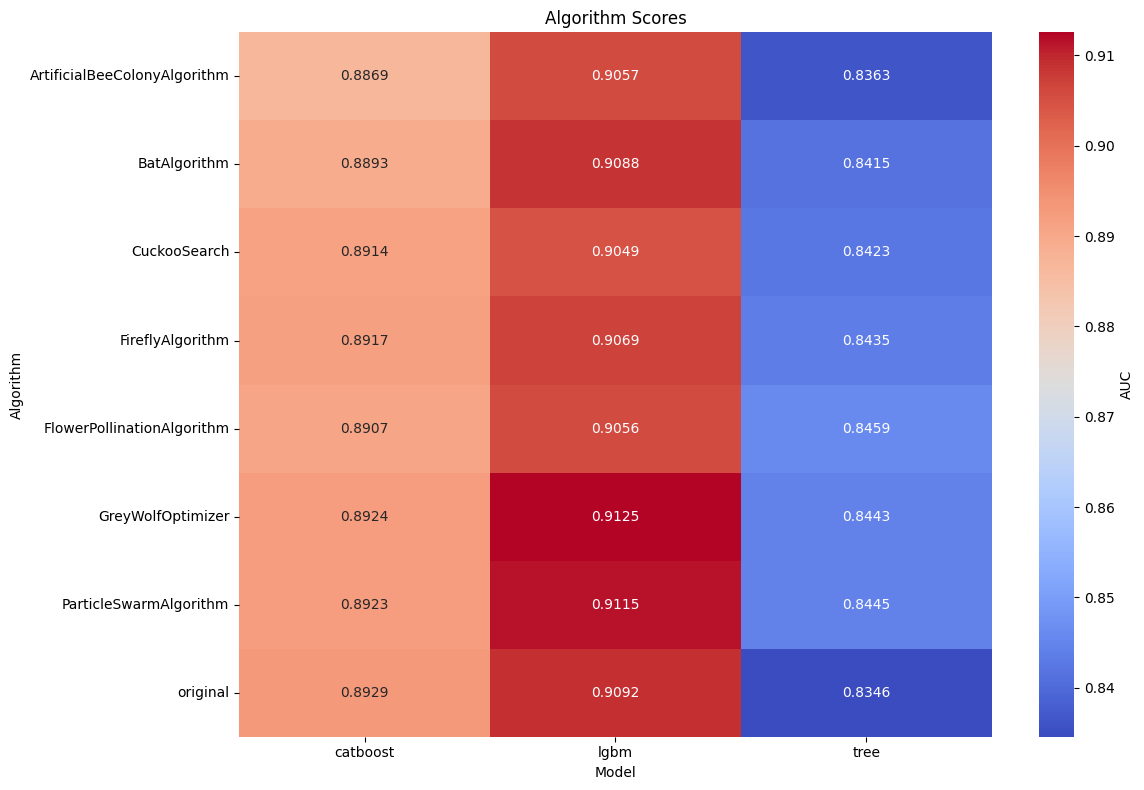

In [63]:
algo_scores = results.pivot_table(index="algorithm", columns="model", values="score")

algo_scores.to_csv("algorithm_scores.csv")

plt.figure(figsize=(12, 8))

sns.heatmap(
    algo_scores,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar_kws={"label": "AUC"},
)
plt.title("Algorithm Scores")
plt.xlabel("Model")
plt.ylabel("Algorithm")
plt.tight_layout()
plt.savefig("algorithm_scores.png")
plt.show()